# Matching sensitivities
* One can hedge a position e.g. with long put options on the underlying.
* The total portfolio is *delta-neutral* if the number of options is chosen correctly.
* However, the total portfolio is general not neutral anymore in terms of the rest of the greeks.
* One can add more positions to the portfolio to become neutral in all greeks.
$\newcommand{\M}{\mathbf{M}} \newcommand{\x}{\mathbf{x}} \newcommand{\y}{\mathbf{y}}$

In [1]:
import numpy as np
import pandas as pd

In [2]:
num_greeks = 4
num_options = 600

For simplicity, assume each option has a different mix of greeks. The matrix $\M$ contains the greeks for all options. Each option is a column:

In [3]:
np.random.seed(1)
M = np.random.random((num_greeks, num_options))
M.shape

(4, 600)

* Our aim is to find out how much of each option to purchase.
* In the vector $\x$ each entry $\x_i$ encodes how much of each option to buy or sell. Positive value for $\x_i$ are long positions, and negative values short positions.
* The target exposure in term of greeks is encoded in the vector $\y$. Since there are 4 greeks, $\y \in \mathbb{R}^4$.
* The delta entry in $\y$ is equal to -1 to offset the underlying, which has delta 1. Therefore: $\y = [-1, 0, 0, 0]$.

The problem in terms of solving a linear system of equations is: $$ \M \x = \y $$

**Note**: We cannot use `np.lingalg.solve(M, y)` because M is not a square matrix. Instead we use least squares. Which amounts to solving a minimization problem: $$ \min_\x || \M \x - \y ||_2 $$

In [4]:
y = np.array([-1, 0, 0, 0])
x, *_ = np.linalg.lstsq(M, y, rcond=None)

We can see that $\M \x = \y$. But also, we are taking diminute positions in each option:

In [5]:
def error(yhat):
    return np.linalg.norm(y - yhat)

print(M @ x)
print(error(M @ x))

[-1.00000000e+00 -2.88657986e-15 -1.91166527e-15 -1.83013327e-15]
4.501841384490859e-15


In [6]:
pd.Series(x).describe(percentiles=[.1, .5, .9, .99])

count    600.000000
mean      -0.000763
std        0.004916
min       -0.012770
10%       -0.007301
50%       -0.001179
90%        0.005843
99%        0.009362
max        0.011563
dtype: float64

Instead of taking many small positions, we would like to take few a couple larger positions. This will make actual trading significantly simpler and save transaction costs. 

## Encouraging Sparse Solutions: Lasso
* There are many ways to combine 600 different options to the 4 greeks in $\y$. The solution is underdetermined.
* Therefore `np.lingalg.lstsq(M, y)` finds the solution for that minimizes the L2 norm of $\x$.
* To find as solution $\x$ with many zeros as possible, we want to minimize instead the L1 norm of $\x$ (as an approximation).
* This can be achieved with Lasso regression.

In the Lasso regression below
* I found the parameters for `alpha` and `fit_intercept` by trial and error.
* the solution for $\x$ is close to $\y$, but not quite equal (within 1%)
* It uses only 5 options rather than 600.

In [7]:
from sklearn.linear_model import Lasso

In [8]:
def lasso(alpha: float) -> np.ndarray:
    lasso = Lasso(alpha=alpha, max_iter=10000, fit_intercept=False)
    lasso.fit(M, y)
    return lasso.coef_

%timeit lasso(alpha=0.001)
x2 = lasso(alpha=0.001)
error(M @ x2)

18.2 ms ± 33.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.005877870054588706

In [9]:
x2[x2 != 0]

array([ 0.20949149, -0.11422789, -0.88781702, -0.02357888])

#### Optimal $\alpha$
* Let's try different values for `alpha` and find their trade-offs.
* A higher `alpha` encourages sparsity more, but increases the error of $\M \x - \y$. We can reduce the error by reducing `alpha`.
* However, at a certain point where the sparsity breaks down, and the number of option positions shoots up.

In [10]:
alphas = 10.0 ** -np.linspace(2, 4, 20)
errors = [error(M @ lasso(a)) for a in alphas]
numopts = [(~np.isclose(lasso(a), 0)).sum() for a in alphas]

/Users/tomasruiz/code/python-for-finance/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e-04, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/Users/tomasruiz/code/python-for-finance/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e-04, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


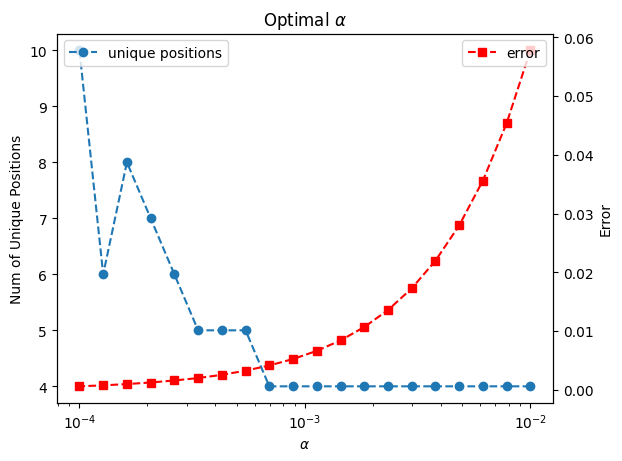

In [11]:
import matplotlib.pyplot as plt
plt.title(r"Optimal $\alpha$")
plt.plot(alphas, numopts, marker="o", linestyle="--", label="unique positions")
plt.xlabel(r"$\alpha$")
plt.ylabel("Num of Unique Positions")
plt.xticks(alphas)
plt.legend(loc="upper left")
ax2 = plt.twinx()
ax2.set_ylabel("Error")
ax2.plot(alphas, errors, marker='s', linestyle='--', color='r', label="error")
plt.xscale('log')
plt.legend(loc="upper right")
plt.show()

## OMP: A Greedy Algorithm for Sparsity
* ChatGPT suggested I try the [OMP algorithm](https://scikit-learn.org/stable/modules/linear_model.html#orthogonal-matching-pursuit-omp), with the disclaimer that it might not scale to larger problems. 
* Since our search space is not huge (600 options), this might not be a problem.
* In fact, timing the algorithm reveals that it is at least an order of magnitude faster than Lasso.
* Below we achieve exact results, using 4 options.

In [12]:
from sklearn.linear_model import orthogonal_mp, OrthogonalMatchingPursuit

%timeit orthogonal_mp(M, y, tol=1e-4)
x3 = orthogonal_mp(M, y, tol=1e-4)

197 µs ± 734 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
error(M @ x3)

0.007418781045996719

In [14]:
x3[x3 != 0]

array([-0.58492361,  0.57690631, -0.44261911])

* OMP can take explicitly a number of options to use (non-zero entries in $\x$).
* Let's see how far we can get with only 1, 2, 3, ... options.
* The solution is exact at 4 and does not get better afterwards, which makes intuitive sense, since a combination of 4 linearly independent options suffices to replicate any greek vector.

In [15]:
numopts = list(range(1, 7))
errors = [error(M @ orthogonal_mp(M, y, n_nonzero_coefs=n)) for n in numopts]

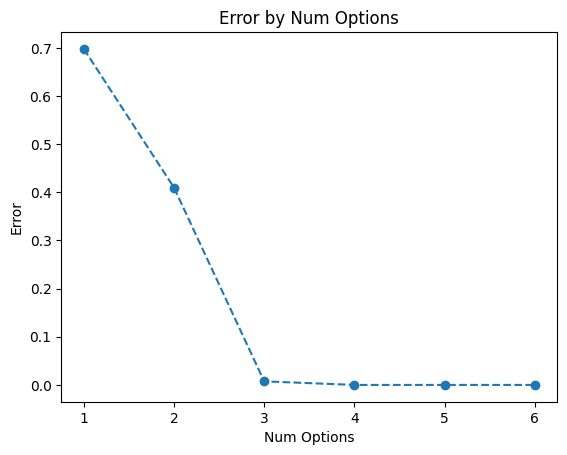

In [16]:
plt.plot(numopts, errors, marker="o", linestyle="--")
plt.title("Error by Num Options")
plt.xlabel("Num Options")
plt.ylabel("Error")
plt.xticks(numopts)
plt.show()